# Monte Carlo calculation of volumes and areas 

This notebook contains the Monte Carlo (MC) calculations of volumes and areas for the problem of two spheres ( 3d "discs") in a hard box.

In [1]:
using Distributions, Plots

In [2]:
h1 = 1
h2 = 1.5
h3 = 1.75

1.75

Exact analytical expressions derived in the paper:

In [3]:

# esta es otra hjay que cambiarla
cte = 3π/2   # E = 1/2 => abs(v^2) = 1 
sr2= sqrt(2)

# Esto puede no ser valido para 3d
# de hecho ninguno de estos aplica para 3D!
rhmax = h1/4  # maximum radius for which horizontal hop possible
rvmax = h2/4  # maximum radius for which vertical hop possible
rpmax = h3/4  
#rmax = ( h + w - √(2*h*w) ) / 2   # maximum possible radius for discs

volBox(a1, a2, a3) = 64 *a1^2*a2^2*a3^2
volNegfree(a1, a2, a3, r) = 64* ( (sr2*r)^3*π/6*a1*a2*a3*sr2^3
                            -(sr2*r)^4/16*π*(a1*a2+a2*a3+a3*a1)*sr2^2
                            +(sr2*r)^5/15*(a1+a2+a3)*sr2
                            -(sr2*r)^6/48)


# The neg volume is much much smaller than the full box
# in order to appreciate errors, we shall thest ONLY the neg volume
function vol(a, b, c, r)
    #result = volBox(a, b, c) - volNegfree(a, b, c, r)
    result =  volNegfree(a, b, c, r)
    
    return result
end 

vol (generic function with 1 method)

In [4]:
testvolneg(r)=volNegfree(h1/2-r, h2/2-r, h3/2-r,r)
testvolbox(r)=volBox(h1/2-r, h2/2-r, h3/2-r)

testvolbox (generic function with 1 method)

In [5]:
rangsr=0:0.01:0.285
volxul=map(testvolneg, rangsr);
volb=map(testvolbox, rangsr);

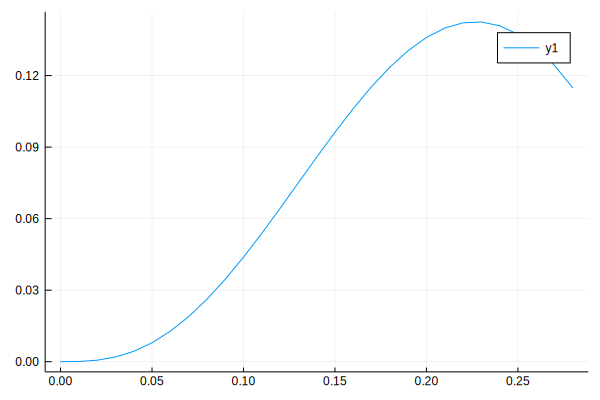

In [6]:
plot(rangsr, volxul)
#plot!(rangsr, volb)

In [7]:
"Available volume in configuration space"
function MC_volume(a, b, c, r, N=10^7)

    valid = 0
    
    for n in 1:N
        x1, x2 = rand(Uniform(-a, a), 2)
        y1, y2 = rand(Uniform(-b, b), 2)
        z1, z2 = rand(Uniform(-c, c), 2)
        ## Test ONLY negated Volume, not avaible Volume
        if (x1-x2)^2 + (y1-y2)^2 +(z1-z2)^2  <= (2r)^2  # non-overlapping condition
            valid += 1
        end
    end
    
    p = valid / N
    σ² = p * (1 - p) / N   # estimated variance of binomial distribution
    σ = √(σ²)
    vbox=volBox(a,b,c)
    
    return ( vbox * p, vbox * σ )
    
end

MC_volume

In [8]:
volprop3d=MC_volume(1,1,1,0.5)

(17.6902336, 0.009051135760651429)

In [9]:
"Area for horizontal hopping in configuration space"
function MC_horiz_hop_area3D(a, b, c, r, N=10^7, ϵ=0.001)
    
    valid = 0
    
    for n in 1:N
        x1, x2 = rand(Uniform(-a, a), 2)
        y1, y2 = rand(Uniform(-b, b), 2)
        z1, z2 = rand(Uniform(-c, c), 2)
        
        if (x1 - x2)^2 + (y1 - y2)^2 + (z1-z2)^2 < (2r)^2   # overlapping for testing first
            
            if abs(x1 - x2) < (ϵ * √2)  # horizontal hopping condition; factor √2 from diagonal orientation
                valid += 1
            end
        end
    end
    
    p = valid / N
    σ² = p * (1 - p) / N
    σ = √(σ²)
    vbox=volBox(a,b,c)
    
    return ( vbox * p / (2ϵ), (vbox  * σ) / (2ϵ) )   # factor of 2 since area is "2-sided"
end

MC_horiz_hop_area3D

In [10]:
 """ Area for collitions Monte Carlo"""

function MC_collision_area3D(a, b, c, r, N=10^7, ϵ=1e-3)
    
    valid = 0
    
    for n in 1:N
        x1, x2 = rand(Uniform(-a, a), 2)
        y1, y2 = rand(Uniform(-b, b), 2)
        z1, z2 = rand(Uniform(-c, c), 2)
        
        ρ = √( (x1 - x2)^2 + (y1 - y2)^2 + (z1 - z2)^2)
        
        if  0 < ρ - 2r < (ϵ)   
            valid += 1
        end
    end
    
    p = valid / N
    σ² = p * (1 - p) / N
    σ = √(σ²)
    vbox=volBox(a,b,c)
    
    return ( vbox * p) / ϵ,  ((vbox * σ) / ϵ )
end


MC_collision_area3D (generic function with 3 methods)

In [11]:
""" Area for hitting the third wall on 3D---- that is the h3 or c direction """

function MC_wall_area3D(a, b, c, r, N=10^7, ϵ=1e-3)
        
    valid = 0
    
    for n in 1:N
        x1, x2 = rand(Uniform(-a, a), 2)
        y1, y2 = rand(Uniform(-b, b), 2)
        z1, z2 = rand(Uniform(-c, c), 2)
        
        if  (x1 - x2)^2 + (y1 - y2)^2 + (z1 - z2)^2 <= (2*r)^2   # overlapping condition for testing
         
            if c - ϵ < z1 < c  # collision of disc 1 with right wall
                valid += 1
            end
            
        end
    end
    
    p = valid / N
    σ² = p * (1 - p) / N
    σ = √(σ²)
    
    vbox=volBox(a,b,c)
    
    return ( vbox * p) / ϵ,  ((vbox * σ) / ϵ )
end


MC_wall_area3D (generic function with 3 methods)

## Generic MC function

In [13]:
function run_MC(MC_func, exact_func, rmax, N=10^6)
    h1, h2, h3 = 1.5, 1.2, 1

    numerical_data = Float64[]
    sigma_data = Float64[]  # standard deviation
    exact_data = Float64[]

    rs = Float64.(0.01:0.005:rmax)

    for r in rs

        print(r, " ")

        a = h1/2 - r
        b = h2/2 - r
        c=  h3/2 -r
        
        μ, σ =  MC_func(a, b, c, r, N)

        push!(numerical_data, μ)
        push!(sigma_data, σ)
        push!(exact_data, exact_func(a, b,c, r))
    end
    
    return rs, numerical_data, sigma_data, exact_data
end

run_MC (generic function with 2 methods)

## MC calculation of free volume

In [14]:
rs, numerical_V_data, sigma_V_data, exact_V_data = run_MC(MC_volume, vol, 0.25)

0.01 0.015 0.02 0.025 0.03 0.035 0.04 0.045 0.05 0.055 0.06 0.065 0.07 0.075 0.08 0.085 0.09 0.095 0.1 0.105 0.11 0.115 0.12 0.125 0.13 0.135 0.14 0.145 0.15 0.155 0.16 0.165 0.17 0.175 0.18 0.185 0.19 0.195 0.2 0.205 0.21 0.215 0.22 0.225 0.23 0.235 0.24 0.245 0.25 

([0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055  …  0.205, 0.21, 0.215, 0.22, 0.225, 0.23, 0.235, 0.24, 0.245, 0.25], [5.858272813567999e-5, 0.00023379173158395592, 0.0003885809367121919, 0.0008331380691874998, 0.0012715447558717436, 0.002136416853931073, 0.002815231684034559, 0.003931160181744976, 0.005305790951999998, 0.006782213257969327  …  0.07363341041554532, 0.07381551239343594, 0.07361376448341764, 0.07331757778796956, 0.07243449341132813, 0.0716743299181179, 0.07029326817978793, 0.06889335201036288, 0.06706892883982056, 0.06517171499999999], [1.3099365246259598e-5, 2.5507697819628624e-5, 3.20472597542197e-5, 4.5716800937665814e-5, 5.501042940042784e-5, 6.942804058897898e-5, 7.758281415465753e-5, 8.92118641168365e-5, 0.0001008179139736677, 0.00011084230590399871  …  0.00011655007180843393, 0.00011032981190835723, 0.00010400104552243682, 9.770566409855756e-5, 9.133321994291834e-5, 8.509799249744275e-5, 7.887951422895357e-5, 7.280800330588531e-5, 6.6875646415264

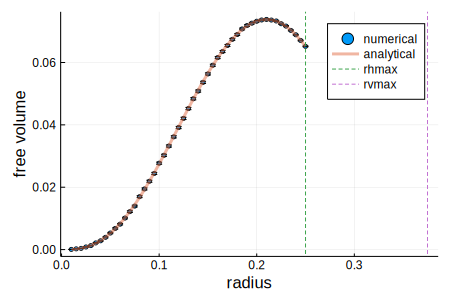

In [15]:
scatter(rs, numerical_V_data, yerror = 2 .* sigma_V_data, markersize=2, lab="numerical", xlabel="radius", ylabel ="free volume")

plot!(rs, exact_V_data, lab="analytical", lw=3, alpha=0.5, size=(450, 300))
vline!([rhmax], ls=:dash, label="rhmax")
vline!([rvmax], ls=:dash, label="rvmax")

In [16]:
maximum(exact_V_data)/maximum(numerical_V_data) # Worst error.

1.0000126823502486

In [17]:
savefig("FreeVolume3D01.pdf")

## MC calculation of hopping areas

In [18]:
""" Explore hops along the first (a or h1) dimension """ 

function area_horiz_hop3D(a, b, c, r)
    vnegbc=16*pi*b*c*r^2-64/3*(b+c)*r^3+8*r^4
    vposbc=16*b^2*c^2
    #result= 2 *sr2* a* (vposbc-vnegbc)
    # dado que los volumenes son pequeños, primero exploramos lo negativo
    result= 2 *sr2* a* vnegbc
    return result
end



area_horiz_hop3D (generic function with 1 method)

In [19]:
rs_A, numerical_A_hop_data, sigma_A_hop_data, exact_A_hop_data = run_MC(MC_horiz_hop_area3D, area_horiz_hop3D, rhmax, 10^7)

0.01 0.015 0.02 0.025 0.03 0.035 0.04 0.045 0.05 0.055 0.06 0.065 0.07 0.075 0.08 0.085 0.09 0.095 0.1 0.105 0.11 0.115 0.12 0.125 0.13 0.135 0.14 0.145 0.15 0.155 0.16 0.165 0.17 0.175 0.18 0.185 0.19 0.195 0.2 0.205 0.21 0.215 0.22 0.225 0.23 0.235 0.24 0.245 0.25 

([0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055  …  0.205, 0.21, 0.215, 0.22, 0.225, 0.23, 0.235, 0.24, 0.245, 0.25], [0.0035149636881407985, 0.006401440269560698, 0.012556186730495997, 0.015056712093749997, 0.022978290063974394, 0.027552098961901788, 0.03789323255316479, 0.04807455949811968, 0.06281656919999998, 0.06582201606930016  …  0.20942062059645145, 0.1996671999568897, 0.1925033684742977, 0.19422265784033288, 0.18475516705078127, 0.17918668834560003, 0.17159979967889694, 0.1643088835454976, 0.1576265550376185, 0.149125375], [0.0007174880973757514, 0.0009438387047162511, 0.0012882314578797525, 0.001374475229009022, 0.0016539975500247017, 0.0017638208743336779, 0.0020139669391834166, 0.002208085316125594, 0.0024562419091387457, 0.002446167405856171  …  0.0016426599669428748, 0.0015424857823010778, 0.0014557075087189698, 0.0014045189073125593, 0.0013151291800677367, 0.0012426409003817335, 0.0011660295594398378, 0.0010933562361511609, 0.0010255035606627511, 0.0009

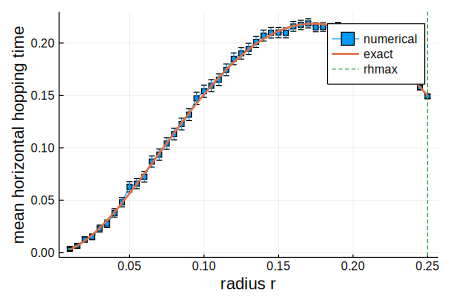

In [20]:
plot(rs_A, numerical_A_hop_data, yerr=2 .* sigma_A_hop_data, m=:square, markersize=2, lab="numerical")
plot!(rs_A, exact_A_hop_data, lw=2, lab="exact", size=(450, 300))
xlabel!("radius r")
ylabel!("mean horizontal hopping time")
vline!([rhmax], label="rhmax", ls=:dash)

In [21]:
savefig("figures/AreaHop01.pdf")

SystemError: SystemError: opening file "/home/karel/postdocSanders/TwoDiskinaRectangle/julia_code/figures/AreaHop01.pdf": No such file or directory

In [22]:
# plot(rs, exact_A_data/2 ./ num_A_data, m=:square)


## Area for disc collisions

In [23]:
""" Analytical Area for Collitions 3D """

function area_col3D(a,b,c,r)
    # asumiendo r<rhopmax
    result= 64 * (2 * π * r^2 * a * b *c 
                - r^3 * π * (a*b+b*c+c*a)
                + 4 * r ^4 / 3* (a+b+c)
                -r^5/2)
end

area_col3D (generic function with 1 method)

In [24]:
rs_C, num_C_data, sigma_C_data, exact_C_data = run_MC(MC_collision_area3D, area_col3D, rhmax, 10^7)

0.01 0.015 0.02 0.025 0.03 0.035 0.04 0.045 0.05 0.055 0.06 0.065 0.07 0.075 0.08 0.085 0.09 0.095 0.1 0.105 0.11 0.115 0.12 0.125 0.13 0.135 0.14 0.145 0.15 0.155 0.16 0.165 0.17 0.175 0.18 0.185 0.19 0.195 0.2 0.205 0.21 0.215 0.22 0.225 0.23 0.235 0.24 0.245 0.25 

([0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055  …  0.205, 0.21, 0.215, 0.22, 0.225, 0.23, 0.235, 0.24, 0.245, 0.25], [0.008494495579673599, 0.015864438928911293, 0.02907748506009599, 0.04993809511093748, 0.07381626859929599, 0.09394814072255035, 0.10190496438026236, 0.13164721145265684, 0.14734039319999995, 0.1760102529145927  …  0.3962562848828154, 0.3770854962361346, 0.36087903057168275, 0.3441585606287361, 0.320228532421875, 0.3035897453242368, 0.2856317613275314, 0.2605549650223104, 0.2383190460466938, 0.21706999999999996], [0.00157738594209637, 0.0021012902800996314, 0.0027724141710111757, 0.0035399824804548353, 0.004192417347113254, 0.004606090755804211, 0.00467069521784015, 0.005167437381737405, 0.005319949217653855, 0.005656909976326602  …  0.0031956562867897376, 0.002997940361016527, 0.00281886692057465, 0.002644352004936138, 0.002448906914206282, 0.0022878119834780658, 0.0021278856741091218, 0.0019475893285616527, 0.001783782982690976, 0.0016292315862117329

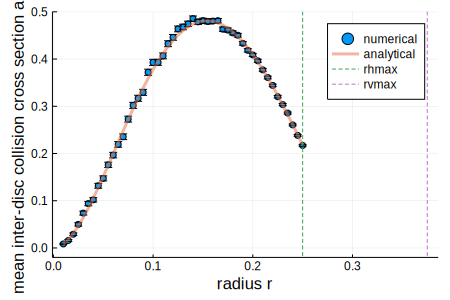

In [25]:
scatter(rs_C, num_C_data, yerror=sigma_C_data, markersize=3, lab="numerical", ylim=(-0.02,0.5))
plot!(rs_C, exact_C_data, lab="analytical", lw=3, alpha=0.5, size=(450, 300))
xlabel!("radius r")
ylabel!("mean inter-disc collision cross section area")
vline!([rhmax], label="rhmax", ls=:dash)
vline!([rvmax], label="rvmax", ls=:dash)

In [26]:
savefig("figures/AreaCol01.pdf")

SystemError: SystemError: opening file "/home/karel/postdocSanders/TwoDiskinaRectangle/julia_code/figures/AreaCol01.pdf": No such file or directory

In [27]:
# plot(rs, exact_C_data ./ num_C_data, m=:square)

## Area for wall collisions

In [119]:
" It hits the h3 or c wall (the third wall)"
function area_wall3D(a, b, c, r)
    
    partepositiva= 32 * c * a^2 * b^2
    partenegativa= (64 * pi * (a * b ) * r^3/3 
                    - 8 * pi * ( a + b) * r^4 
                    + 128/15 * r ^5)
    #-pi/4 * r^4 * (a + b) 
    #2/3 * r^3 * a * b 
    #+4/15 * r^5  +pi/4 * r^4 * (a + b) 
    
    #result = partepositiva - partenegativa probemos negativa sola primero
    result = partenegativa
    
    return result
end

area_wall3D

In [120]:
rs_W, num_W_data, sigma_W_data, exact_W_data = run_MC(MC_wall_area3D, area_wall3D, rhmax, 10^8)

0.01 0.015 0.02 0.025 0.03 0.035 0.04 0.045 0.05 0.055 0.06 0.065 0.07 0.075 0.08 0.085 0.09 0.095 0.1 0.105 0.11 0.115 0.12 0.125 0.13 0.135 0.14 0.145 0.15 0.155 0.16 0.165 0.17 0.175 0.18 0.185 0.19 0.195 0.2 0.205 0.21 0.215 0.22 0.225 0.23 0.235 0.24 0.245 0.25 

([0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055  …  0.205, 0.21, 0.215, 0.22, 0.225, 0.23, 0.235, 0.24, 0.245, 0.25], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.07743413592030003, 0.023872214246400014, 0.0661637286387, 0.06105710714880001, 0.11255835937499999, 0.13816804884480005, 0.1270462632392, 0.1312546000896, 0.12037666485689999, 0.07349999999999998], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.04469991272214366, 0.02387102060584593, 0.03819391616335128, 0.03524604915107522, 0.04593797019647352, 0.048830238318333274, 0.044899666480723535, 0.04373184074134926, 0.040107494388029775, 0.02999724612360274], [2.8927800729547195e-5, 9.558503825575441e-5, 0.00022177180701156668, 0.0004238710923332065, 0.0007165885027092647, 0.0011129994520778519, 0.0016245963421237474, 0.002261335744575548, 0.003031685583502826, 0.003942672317613266  …  0.08566366045894361, 0.0887430056609685, 0.0917090795918971, 0.0945478096221963, 0.09724528585507433, 0.0997878

In [121]:
# guarda los datos de 10^7 en las variables num_W_data, sigma_W_data
# usa otras variables para 10^5  y que nomas te salga la "analitica " bien.

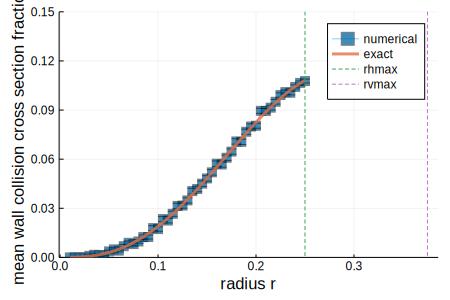

In [123]:
plot(rs_W, num_W_data, yerror=sigma_W_data, m=:square, lab="numerical", ylim=(0.00,0.15), alpha=0.5)
plot!(rs_W, exact_W_data, lab="exact", lw=3, size=(450, 300), alpha=0.8)
xlabel!("radius r")
ylabel!("mean wall collision cross section fraction")
vline!([rhmax], label="rhmax", ls=:dash)
vline!([rvmax], label="rvmax", ls=:dash)

In [67]:
savefig("figures/AreaWall01.pdf")

SystemError: SystemError: opening file "/home/karel/postdocSanders/TwoDiskinaRectangle/julia_code/figures/AreaWall01.pdf": No such file or directory